# FIXME

1. [x] Clean up the file
  - [x] Clean up the imports
  - [x] Clean up the helper functions - ultimately these should use the libraries
  - [x] Clean up the plots
2. [ ] Figure out exactly which variables need to be swept over
  - [ ] The required variables are apr, time, and the percent of the bond ratio.
  - [ ] Are share price and initial share price essential? What we can do is start without them and see how bad the approximation is with non-trivial values.
3. [ ] Write the sweeping logic and sanity check it
4. [ ] Write the naive interpolation logic
5. [ ] Ensure that our approximation never overshoots. This is currently a problem, which will given inaccurate results.

# Methods

We desire an approximation for the maximum amount of bonds that a trader can short given the ratio of their cash balance to the AMMs cash reserve. To do this, we can calculate the maximum loss for short positions opened with a range of APRs, time remaining, and ratios of bonds to the total bond reserves. For a fixed APR and time remaining, we'll have an array of the maximum loss and the bond ratios shorted. We can find an approximation that tightly fits these points, which is a function of a max loss in base that outputs the ratio of bonds required to hit the max loss.

## TODO - Add detail about the interpolation.

In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg.special_matrices import math
from scipy.optimize import curve_fit
import scipy

In [108]:
def calc_time_stretch(apr):
    """Returns fixed time-stretch value based on current apr (as a decimal)"""
    apr_percent = apr * 100
    return 3.09396 / (0.02789 * apr_percent)

def stretch_time(time, time_stretch=1.0):
    """Returns stretched time values"""
    return time / time_stretch

def calc_k_const(share_reserves, bond_reserves, share_price, init_share_price, tau):
    """Returns the 'k' constant variable for trade mathematics"""
    scale = share_price / init_share_price
    return scale * (init_share_price * share_reserves) ** (1 - tau) + (bond_reserves) ** (
        1 - tau
    )

def calc_bond_reserves(share_reserves, apr, share_price, init_share_price, t, tau):
    """Calculates the bond reserves from the share reserves and a target apr"""
    return (init_share_price * share_reserves) * (1 + apr * t) ** (1 / tau)

# FIXME: This doesn't incorporate fees
def calc_max_loss(share_reserves, bond_reserves, d_bonds, share_price, init_share_price, tau):
    k = calc_k_const(share_reserves, bond_reserves, share_price, init_share_price, tau)
    d_shares = share_reserves - (1 / init_share_price) * ((init_share_price / share_price) * (k - (bond_reserves + d_bonds) ** (1 - tau))) ** (1 / (1 - tau))
    return d_bonds - d_shares

def calc_max_loss_from_apr(share_reserves, bond_percentage, apr, share_price, init_share_price, t, tau):
    bond_reserves = calc_bond_reserves(share_reserves, apr, share_price, init_share_price, t, tau)
    d_bonds = bond_reserves * bond_percentage
    return calc_max_loss(share_reserves, bond_reserves, d_bonds, share_price, init_share_price, tau)

# FIXME: Comment this
# FIXME: Is there a cleaner way to accomplish this using numpy?
def calc_chebyshev_nodes(start, end, num_points):
    i = np.delete(np.arange(num_points + 1), 0)
    return ((start + end) / 2) + ((end - start) / 2) * np.cos(((2 * i + 1) / (2 * num_points)) * np.pi)

# FIXME: Implement polynomial interpolation
def interpolate_polynomial(xp, yp, num_parameters):
    a = np.vander(xp, num_parameters, True)
    params = np.linalg.solve(a, yp)
    return np.polynomial.Polynomial(params)

# FIXME: Implmenet Remez's algorithm for polynomials

# FIXME: Implement rational interpolation

# FIXME: Implement Remez's algorithm for rationals



# FIXME: Implement general rational curve fitting function using scipy.optimize.curvefit
# FIXME: Document this. 
# FIXME: Try to optimize this using the dot product of the parameter list and vandermonde matrices
def ratfit(xdata, ydata, xtest, ytest, start_degree=2, end_degree=10, verbose=False):
    """Finds the rational polynomial that minimizes the maximum error up to the given degree"""
    def ratobj(num_degree):
        return lambda x, *coeffs: np.polyval(coeffs[:num_degree], x) / (1 + np.polyval(coeffs[num_degree:], x) * x)
    min_error = float("inf")
    min_num_degree = 1
    min_popt = np.ones(1)
    # Compute the least squares optimal rational polynomial over all of the possible degrees
    for degree in range(start_degree, end_degree + 1):
        for div_degree in range(0, degree):
            num_degree = degree - div_degree
            try: 
                # Compute the optimal parameters
                p0 = tuple(np.ones(degree))
                popt, _ = scipy.optimize.curve_fit(ratobj(num_degree), xdata, ydata, p0=p0)
                # Compute the error and the maximum error with the objective function
                error = ytest - ratobj(num_degree)(xtest, *popt)
                error = max(np.amax(error), np.abs(np.amin(error)))
                if verbose: 
                    print(f"num_degree = {num_degree} & div_degree = {div_degree}")
                    print(f"error = {error} & min_error = {min_error}")
                if error < min_error:
                    if verbose:
                        print(f"updated best fit")
                    min_error = error
                    min_num_degree = num_degree
                    min_popt = popt
            except RuntimeError as e:
                if verbose:
                    print(f"ratfit: curve fitting failed for ({num_degree}, {div_degree}) rational with: {e}")
    return lambda x: ratobj(min_num_degree)(x, *min_popt)

In [109]:
t_stretch = calc_time_stretch(0.05)

# FIXME: We may not need to sweep over c, mu, and z.
# Simulation Variables
c = 1                                 # share price
mu = 1                                # init share price
z = 10**6                             # share reserves -- this is arbitrary for this analysis
apr = 0.02                            # apr
t = 0.5                               # unstretched time
tau = stretch_time(0.5, t_stretch)    # stretched time
y_percent = 0.1                       # percent of bond reserves to be shorted

# Other Variables
verbose = True

In [110]:
# FIXME: This will ultimately be where the sweep code lives.
# FIXME: We should be able to start at zero. We may need to add a constant term
#        to the log.
 
# Capture an array of max losses (the x component) and the bond ratios (the y component) 
# that require the max losses.
y = calc_chebyshev_nodes(0, 100, 100)
x = (calc_max_loss_from_apr(z, 0.01 * y, apr, c, mu, t, tau) / z) * 100

# Construct a new trace of sample data to test for the error
y_test = np.delete(np.arange(0, 100, 0.001), 0)
x_test = (calc_max_loss_from_apr(z, 0.01 * y_test, apr, c, mu, t, tau) / z) * 100

# Filter out any NaN values.
y = np.take(y, np.where(np.isnan(x) == False))[0]
x = np.delete(x, np.where(np.isnan(x) == True))
y_test = np.take(y_test, np.where(np.isnan(x_test) == False))[0]
x_test = np.delete(x_test, np.where(np.isnan(x_test) == True))

if verbose:
    print(
        f"max loss = {x}"
        f"\nbond percentages = {y}"
    )

max loss = [3.83193448e+00 3.58686509e+00 3.37706784e+00 3.18712497e+00
 3.01135293e+00 2.84677267e+00 2.69156088e+00 2.54449473e+00
 2.40470182e+00 2.27153090e+00 2.14447807e+00 2.02314188e+00
 1.90719424e+00 1.79636096e+00 1.69040815e+00 1.58913250e+00
 1.49235419e+00 1.39991153e+00 1.31165699e+00 1.22745402e+00
 1.14717473e+00 1.07069794e+00 9.97907702e-01 9.28692183e-01
 8.62942686e-01 8.00552949e-01 7.41418581e-01 6.85436627e-01
 6.32505243e-01 5.82523464e-01 5.35391049e-01 4.91008388e-01
 4.49276468e-01 4.10096883e-01 3.73371889e-01 3.39004494e-01
 3.06898579e-01 2.76959045e-01 2.49091983e-01 2.23204868e-01
 1.99206762e-01 1.77008541e-01 1.56523125e-01 1.37665721e-01
 1.20354069e-01 1.04508698e-01 9.00531780e-02 7.69143716e-02
 6.50226863e-02 5.43123189e-02 4.47214934e-02 3.61926898e-02
 2.86728616e-02 2.21136405e-02 1.64715255e-02 1.17080565e-02
 7.78996897e-03 4.68932939e-03 2.38365035e-03 8.55983632e-04
 9.49908321e-05 9.49908321e-05]
bond percentages = [6.61958709e+01 6.47020

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in power


Text(0, 0.5, 'Bond Percent')

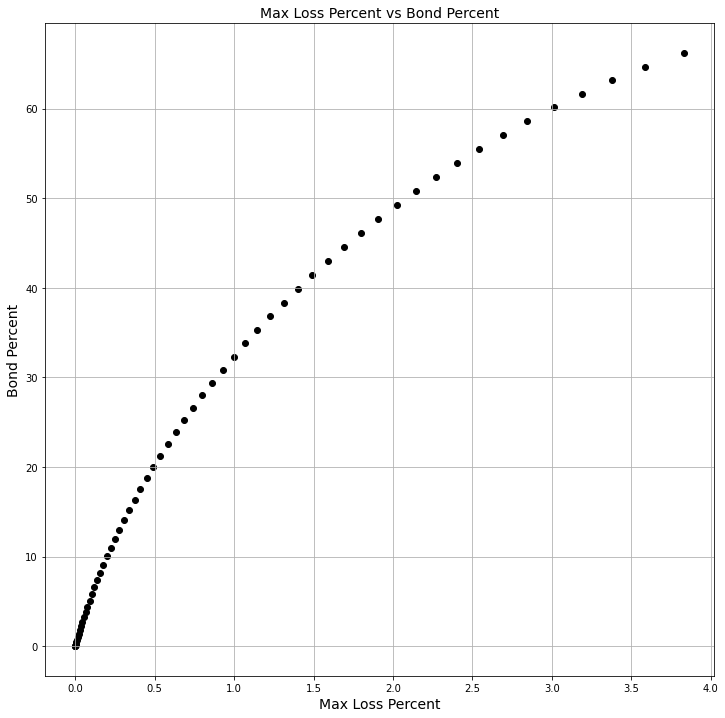

In [111]:
# Plot the raw data output by the sweep
plt.subplots(figsize=(12,12))
plt.scatter(x,y,color='black')
plt.grid(True)
plt.title('Max Loss Percent vs Bond Percent', fontsize=14)
plt.xlabel('Max Loss Percent', fontsize=14)
plt.ylabel('Bond Percent', fontsize=14)

In [103]:
f_approx = ratfit(x, y, x_test, y_test, start_degree=1, end_degree=20, verbose=verbose)

num_degree = 1 & div_degree = 0
error = 50.998876632376934 & min_error = inf
updated best fit
num_degree = 2 & div_degree = 0
error = 11.911879224019195 & min_error = 50.998876632376934
updated best fit
num_degree = 1 & div_degree = 1
error = 29.542492636006557 & min_error = 11.911879224019195
num_degree = 3 & div_degree = 0
error = 6.58087532260781 & min_error = 11.911879224019195
updated best fit
num_degree = 2 & div_degree = 1
error = 4.682251884889519 & min_error = 6.58087532260781
updated best fit
num_degree = 1 & div_degree = 2
error = 20.14281762929677 & min_error = 4.682251884889519
num_degree = 4 & div_degree = 0
error = 4.432068658372317 & min_error = 4.682251884889519
updated best fit
num_degree = 3 & div_degree = 1
error = 1.7071098354156784 & min_error = 4.432068658372317
updated best fit
num_degree = 2 & div_degree = 2
error = 2.5984798027425677 & min_error = 1.7071098354156784
num_degree = 1 & div_degree = 3
error = 62414.20220304703 & min_error = 1.7071098354156784
num_

/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


num_degree = 15 & div_degree = 4
error = 15.313523184664051 & min_error = 2.9231196393433856e-05
num_degree = 14 & div_degree = 5
error = 2.7457021630341845 & min_error = 2.9231196393433856e-05
num_degree = 13 & div_degree = 6
error = 69.76790329356902 & min_error = 2.9231196393433856e-05
num_degree = 12 & div_degree = 7
error = 0.973513664042871 & min_error = 2.9231196393433856e-05
num_degree = 11 & div_degree = 8
error = 0.4513625704304296 & min_error = 2.9231196393433856e-05
num_degree = 10 & div_degree = 9
error = 1.7982700908317217e-05 & min_error = 2.9231196393433856e-05
updated best fit
num_degree = 9 & div_degree = 10
error = 1.8462992798590205e-05 & min_error = 1.7982700908317217e-05
num_degree = 8 & div_degree = 11
error = 0.7144220842429796 & min_error = 1.7982700908317217e-05
num_degree = 7 & div_degree = 12
error = 2.876830511739569 & min_error = 1.7982700908317217e-05
num_degree = 6 & div_degree = 13
error = 3.8402231765688093 & min_error = 1.7982700908317217e-05
ratfit: 

In [104]:
error = y_test - f_approx(x_test)

# Calculate the error averages and extrema
print(f"median error = {np.median(error):.20f}")
print(f"average error = {np.average(error):.20f}")
print(f"min error = {np.amin(error):.20f}")
print(f"max error = {np.amax(error):.20f}")

median error = -0.00000004085282512278
average error = -0.00000001090106452030
min error = -0.00001348469384393480
max error = 0.00001432999434125559


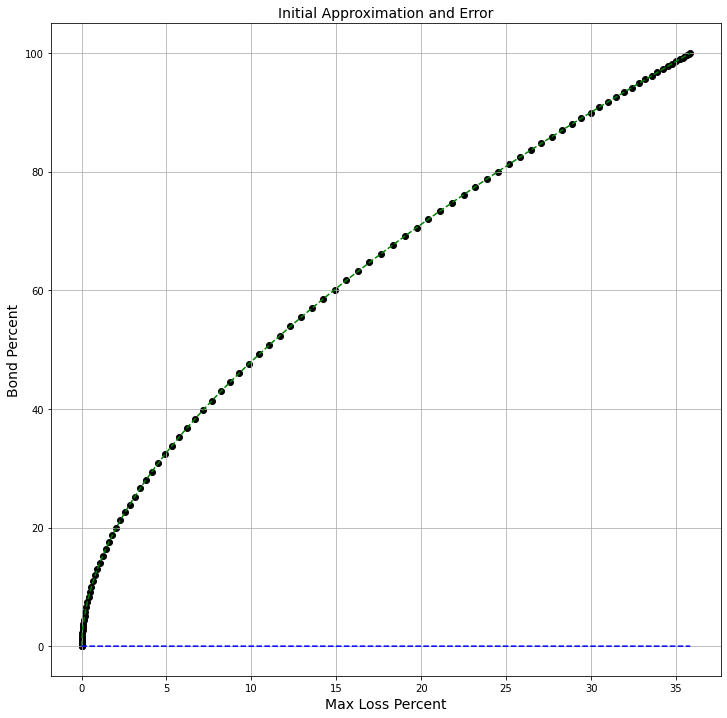

In [105]:
# Plot the Chebyshev approximation against the raw data
plt.subplots(figsize=(12,12))
plt.scatter(x,y,color='black')
# FIXME: It would be good to showcase the fact that we are using different sample data when testing for error.
# plt.scatter(x_test,y_test,color='red')
plt.grid(True)
plt.title('Initial Approximation and Error', fontsize=14)
plt.xlabel('Max Loss Percent', fontsize=14)
plt.ylabel('Bond Percent', fontsize=14)

plt.plot(x_test, f_approx(x_test), '--', color="green")
plt.plot(x_test, y_test - f_approx(x_test), '--', color="blue")

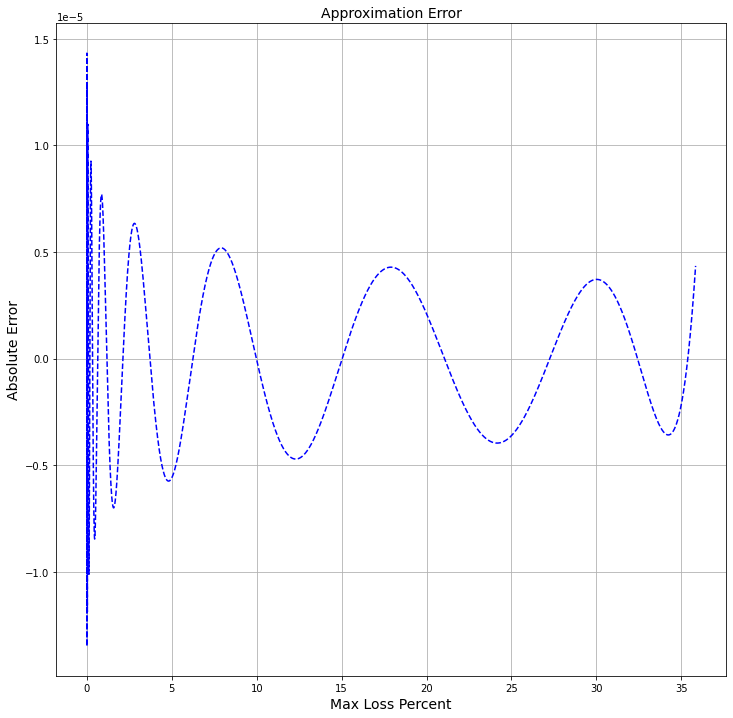

In [106]:
# Plot the absolute error from the initial Chebyshev polynomial
plt.subplots(figsize=(12,12))
plt.grid(True)
plt.title('Approximation Error', fontsize=14)
plt.xlabel('Max Loss Percent', fontsize=14)
plt.ylabel('Absolute Error', fontsize=14)

plt.plot(x_test, y_test - f_approx(x_test), '--', color="blue")